# Scanning MLPs: Achieving Position Invariance

## The Problem: Why Standard MLPs Fail at Position Invariance

For problems like:
- *"Does the word 'welcome' occur anywhere in this signal?"*
- *"Is there a flower anywhere in this image?"*

In these problems:
- **Location does not matter** — we don't care *where* the pattern is
- **Presence does matter** — we only care *if* the pattern exists

### Why Standard MLPs Fail

A standard MLP treats the entire input as a flat vector:

$$\mathbf{y} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$$

**Problems:**
- Moving a pattern by one position produces a **completely different input vector**
- The MLP has **no built-in notion of shift invariance**
- Each weight $w_{ij}$ is tied to a specific input position

---

## The Solution: Scanning

> **Key Insight:** An MLP can be made position-invariant by **scanning** the input instead of consuming it all at once.

### How Do We Scan?

| Step | Description |
|------|-------------|
| **1. Choose window size** | 1D: $K$ time steps, 2D: $K \times K$ pixels |
| **2. Extract local patch** | At position $t$, take subset: $\mathbf{x}_{t:t+K-1}$ |
| **3. Apply SAME MLP** | Identical weights $\mathbf{W}$, identical biases $\mathbf{b}$ |
| **4. Slide and repeat** | Move window by stride $s$, produces one output per location |
| **5. Aggregate outputs** | Max / Softmax / Perceptron → logical OR: "did it occur anywhere?" |

---

## Weight Matrix Structure: Regular vs Scanning MLP

### Regular MLP
- Every neuron connects to **all inputs**
- Weight matrix is **dense**
- Every weight is **unique**

### Scanning MLP
- Each neuron connects to only a **subset of inputs**
- Same subset pattern is **repeated**
- Same weights are **reused** (weight tying)

**Resulting Structure:**
- ✅ Sparse weight matrix
- ✅ Block-structured
- ✅ Identical blocks
- ✅ Shared parameters

> This entire structure is equivalent to **one giant MLP with weight tying**

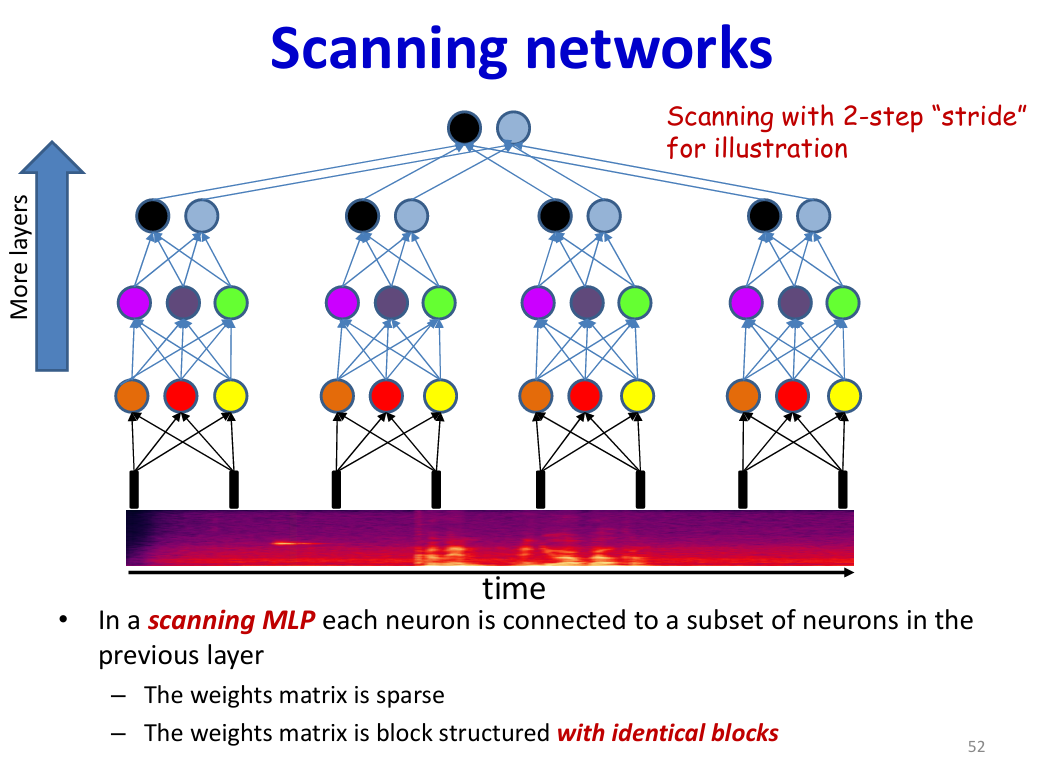

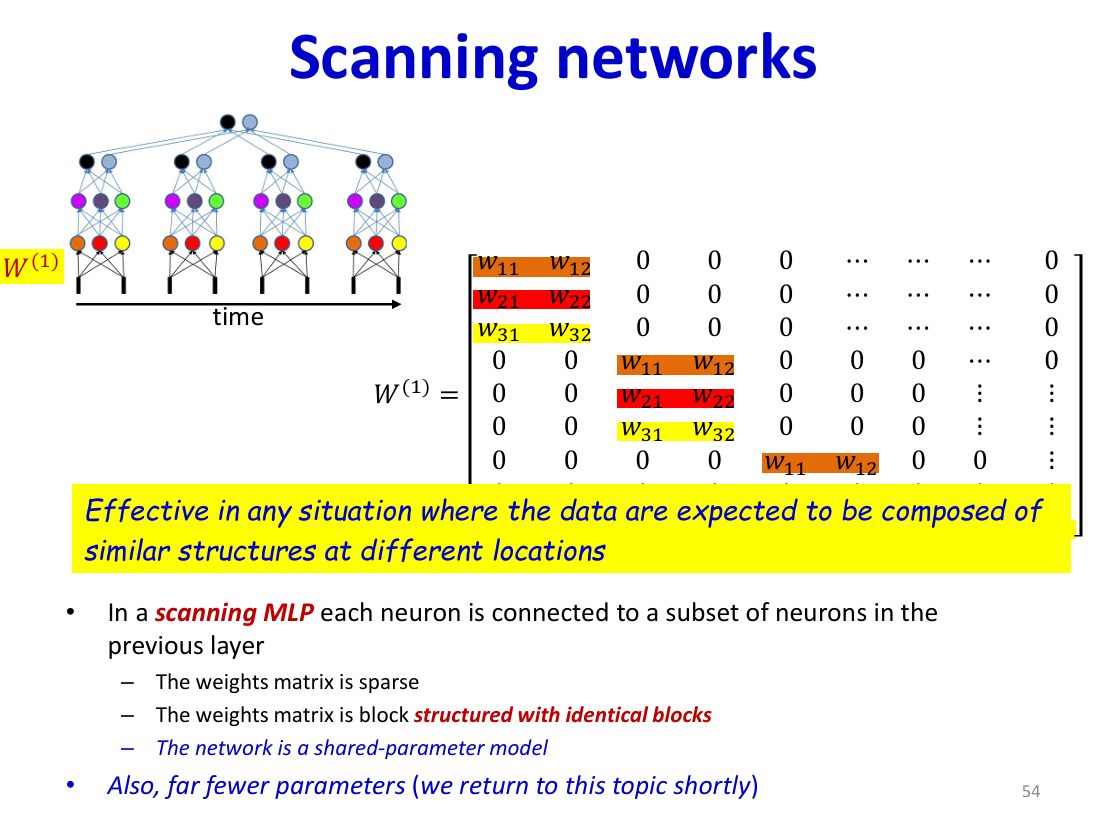

---

## Shared Parameter Model

> *"The network is a shared-parameter model"*

### What This Means:

If a weight $w_{11}$ changes in one location → **it must change everywhere** (every layer it contributes to)

### Training with Shared Parameters

During backpropagation, gradients from all locations are **summed**:

$$\frac{\partial \mathcal{L}}{\partial w_s} = \sum_{t=1}^{T-K+1} \frac{\partial \mathcal{L}}{\partial w_s^{(t)}}$$

where $w_s$ is the shared parameter.

This is what **enforces shift invariance**.

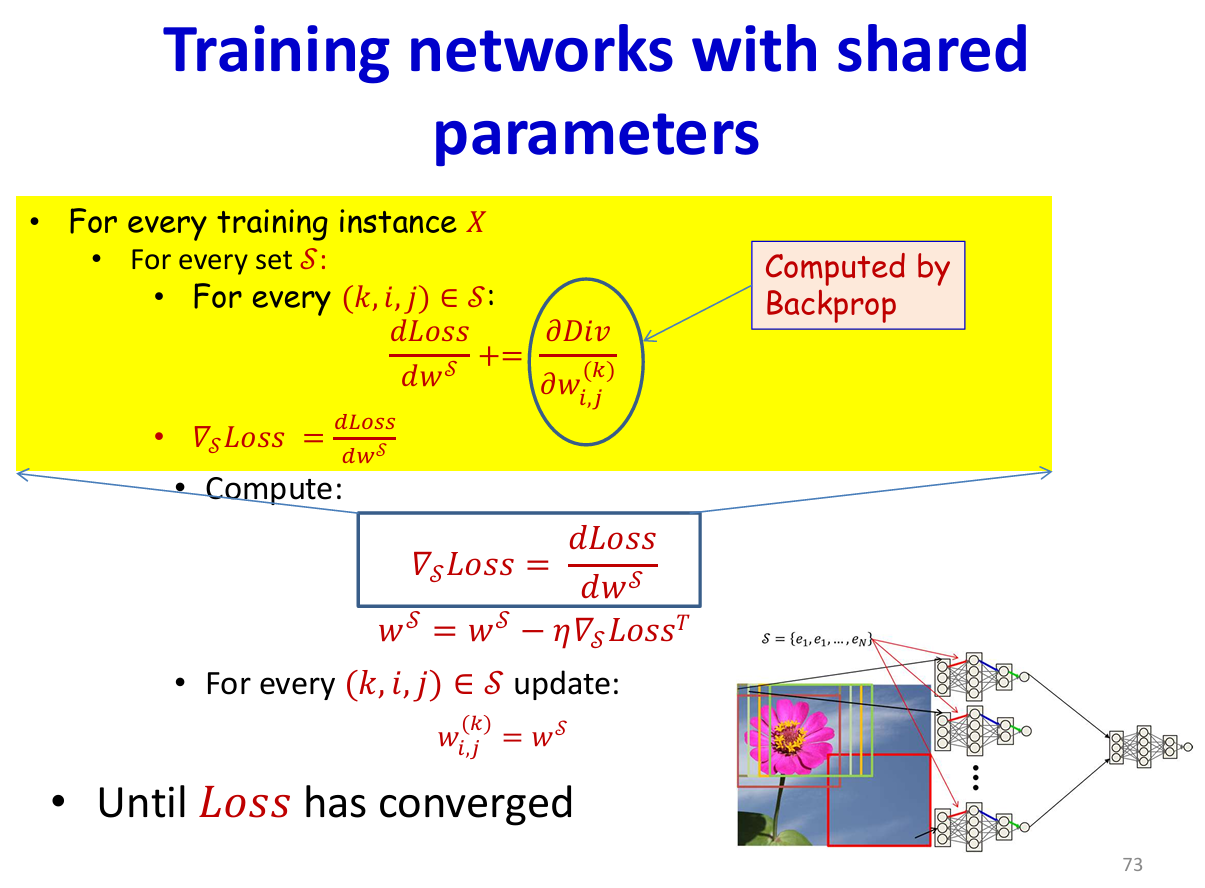

### What is Stride?

> **Stride** ($s$): How far the scanning window moves between evaluations.

$$\text{Output size} = \left\lfloor \frac{T - K}{s} \right\rfloor + 1$$

- Stride $s=1$: Maximum overlap, finest resolution
- Stride $s=K$: No overlap, fastest computation

# Scanning MLP Algorithm (1D)

This algorithm scans an input by sliding a window, applies the **same MLP** at each position using shared weights, computes activations layer-by-layer locally, and aggregates all location-wise outputs into a single decision.

## Algorithm Pseudocode

```
for l = 1:L                    # iterate over layers
    for t = 1:T-K+1            # scan over time/position
        for j = 1:D_l          # neurons in layer l

            if (l == 1)        # first layer operates on input
                y(0,:,t) = x(:, t:t+K-1)
            end

            z(l,j,t) = b(l,j)  # initialize with bias

            for i = 1:D_{l-1}  # sum over previous layer neurons
                z(l,j,t) += w(l,i,j) * y(l-1,i,t)
            end

            y(l,j,t) = activation(z(l,j,t))
        end
    end
end

Y = softmax(y(L,:,1) .. y(L,:,T-K+1))   # aggregate all positions
```

---

## Mathematical Formulation

### Forward Pass at Position $t$

**Layer 1 (Input Layer):**
$$\mathbf{y}^{(0)}_t = \mathbf{x}_{t:t+K-1}$$

**Hidden Layers ($l = 1, \ldots, L$):**

$$z^{(l)}_{j,t} = b^{(l)}_j + \sum_{i=1}^{D_{l-1}} w^{(l)}_{i,j} \cdot y^{(l-1)}_{i,t}$$

$$y^{(l)}_{j,t} = \sigma\left(z^{(l)}_{j,t}\right)$$

**Final Aggregation:**
$$\mathbf{Y} = \text{softmax}\left(\mathbf{y}^{(L)}_{:,1}, \mathbf{y}^{(L)}_{:,2}, \ldots, \mathbf{y}^{(L)}_{:,T-K+1}\right)$$

---

## Symbol Reference Table

| Symbol | Meaning |
|--------|---------|
| $\mathbf{x}$ | Input signal (e.g., spectrogram or time series) |
| $K$ | Window (patch) width |
| $T$ | Total input length |
| $l$ | Layer index |
| $j$ | Neuron index in current layer |
| $i$ | Neuron index in previous layer |
| $D_l$ | Number of neurons in layer $l$ |
| $y^{(l)}_{j,t}$ | Output of neuron $j$ in layer $l$ at position $t$ |
| $z^{(l)}_{j,t}$ | Pre-activation (weighted sum + bias) |
| $w^{(l)}_{i,j}$ | Weight from neuron $i$ (layer $l-1$) to neuron $j$ (layer $l$) |
| $b^{(l)}_j$ | Bias of neuron $j$ in layer $l$ |

---

## Output Dimensions

For input length $T$ and kernel size $K$ with stride $s=1$:

$$\text{Number of output positions} = T - K + 1$$

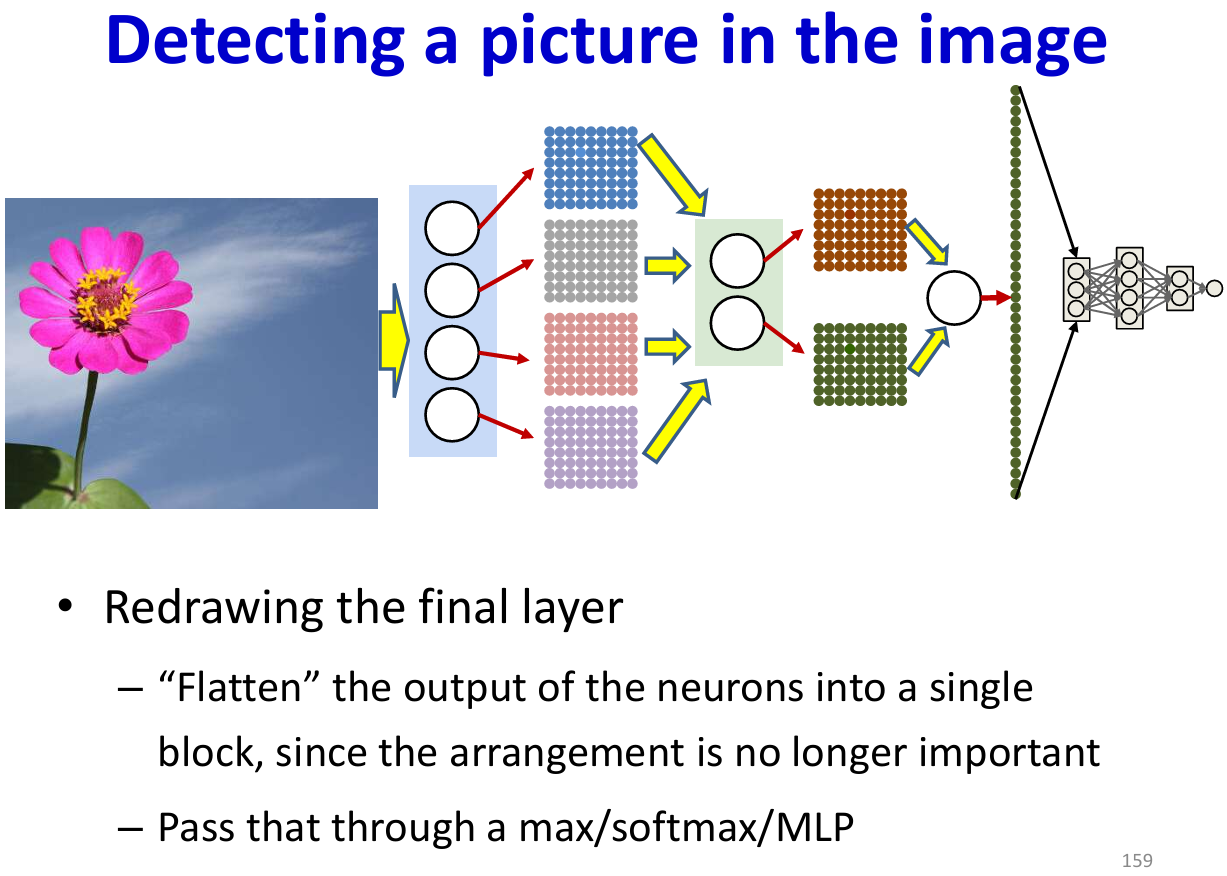

# Convolutional Neural Network (CNN) Algorithm

A CNN extends the scanning MLP to **2D spatial data** (images), scanning with kernels over both width and height dimensions.

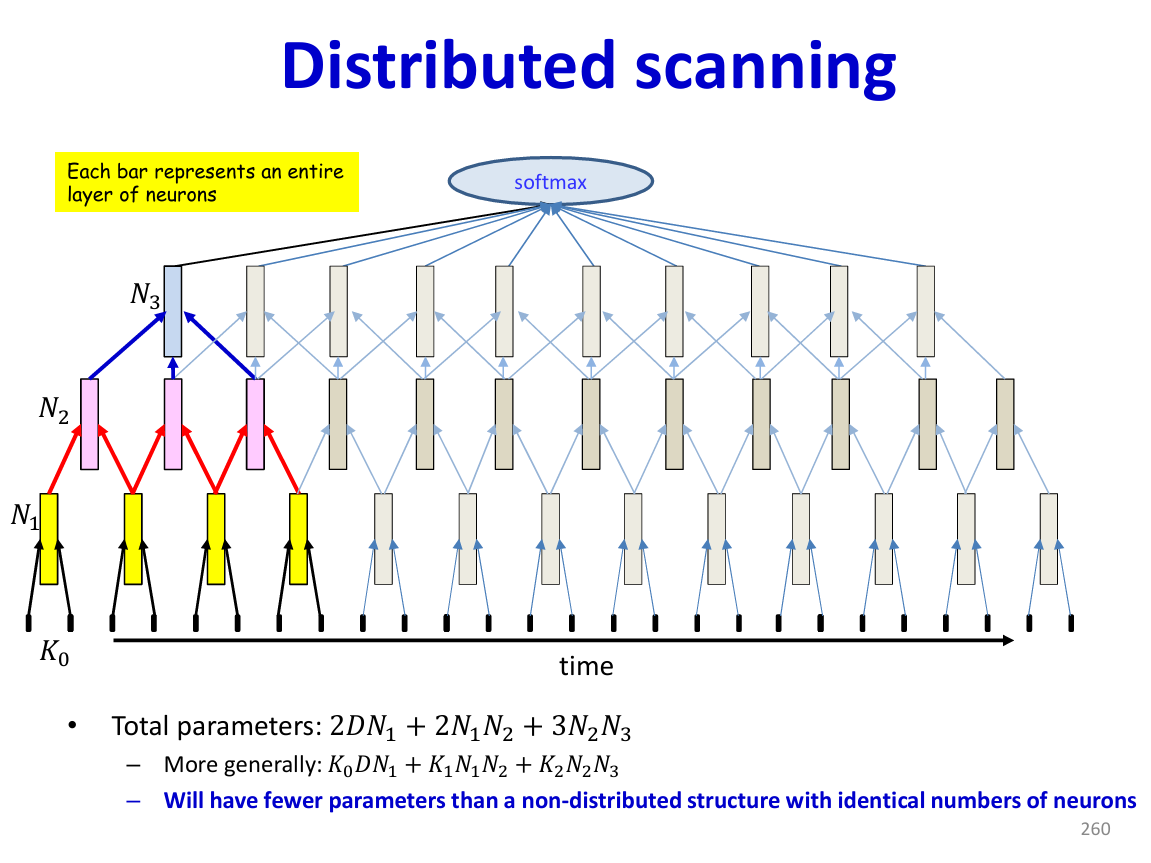

---

## Algorithm Pseudocode

```
Y(0,:,:,:) = Image                              # Initialize with input image

for l = 1:L                                     # iterate over layers
    for x = 1:W_{l-1} - K_l + 1                 # scan over width
        for y = 1:H_{l-1} - K_l + 1             # scan over height
            for j = 1:D_l                       # output filters in layer l

                z(l,j,x,y) = 0                  # initialize accumulator

                for i = 1:D_{l-1}               # input channels
                    for x' = 1:K_l              # kernel width
                        for y' = 1:K_l          # kernel height
                            z(l,j,x,y) += w(l,i,j,x',y') * Y(l-1,i,x+x'-1,y+y'-1)
                        end
                    end
                end

                Y(l,j,x,y) = activation(z(l,j,x,y))
            end
        end
    end
end

Y = softmax( Y(L,:,1,1) .. Y(L,:,W-K+1,H-K+1) )  # aggregate all spatial positions
```

---

## Mathematical Formulation

### Convolution Operation

For each layer $l$, output channel $j$, and spatial position $(x, y)$:

$$z^{(l)}_{j,x,y} = b^{(l)}_j + \sum_{i=1}^{D_{l-1}} \sum_{x'=1}^{K_l} \sum_{y'=1}^{K_l} w^{(l)}_{i,j,x',y'} \cdot Y^{(l-1)}_{i, x+x'-1, y+y'-1}$$

$$Y^{(l)}_{j,x,y} = \sigma\left(z^{(l)}_{j,x,y}\right)$$

### In Compact Notation (Convolution Operator):

$$\mathbf{Y}^{(l)}_j = \sigma\left( \sum_{i=1}^{D_{l-1}} \mathbf{W}^{(l)}_{i,j} * \mathbf{Y}^{(l-1)}_i + b^{(l)}_j \right)$$

where $*$ denotes the 2D convolution operation.

---

## Symbol Reference Table

| Symbol | Meaning |
|--------|---------|
| $\text{Image}$ | Input image (2D signal with channels) |
| $Y^{(l)}_{i,x,y}$ | Output of channel $i$ in layer $l$ at spatial location $(x,y)$ |
| $l$ | Layer index |
| $j$ | Output filter (channel) index |
| $i$ | Input channel index |
| $D_l$ | Number of filters (output channels) in layer $l$ |
| $K_l$ | Kernel (filter) size at layer $l$ |
| $W_l, H_l$ | Width and height of feature maps at layer $l$ |
| $w^{(l)}_{i,j,x',y'}$ | Weight connecting input channel $i$ to output channel $j$ at kernel offset $(x', y')$ |
| $b^{(l)}_j$ | Bias for filter $j$ in layer $l$ |

---

## Output Feature Map Dimensions

For input size $W \times H$, kernel size $K$, padding $P$, and stride $S$:

$$W_{out} = \left\lfloor \frac{W - K + 2P}{S} \right\rfloor + 1$$

$$H_{out} = \left\lfloor \frac{H - K + 2P}{S} \right\rfloor + 1$$

---

## Key Insight

> **A CNN is nothing more than a scanning MLP whose scanning operation has been algebraically reorganized into convolution for efficiency and structure.**

| Scanning MLP | CNN |
|--------------|-----|
| Explicit loop over positions | Convolution operator |
| Same weights at each position | Shared filter weights |
| Sequential computation | Parallelizable matrix operations |

Both achieve **shift invariance** through **weight sharing** across spatial locations.

# Summary: From MLP to CNN

## The Progression

| Concept | Description |
|---------|-------------|
| **Standard MLP** | Dense connections, no spatial awareness, position-dependent |
| **Scanning MLP** | Shared weights, slides over input, achieves shift invariance |
| **CNN** | Scanning MLP reorganized as convolution, efficient 2D extension |

## Key Equations at a Glance

### 1. Standard MLP Layer
$$\mathbf{y} = \sigma(\mathbf{W}\mathbf{x} + \mathbf{b})$$

### 2. Scanning MLP (1D)
$$y^{(l)}_{j,t} = \sigma\left(b^{(l)}_j + \sum_{i} w^{(l)}_{i,j} \cdot y^{(l-1)}_{i,t}\right)$$

### 3. CNN Convolution (2D)
$$Y^{(l)}_{j,x,y} = \sigma\left(b^{(l)}_j + \sum_{i} \sum_{x'} \sum_{y'} w^{(l)}_{i,j,x',y'} \cdot Y^{(l-1)}_{i,x+x'-1,y+y'-1}\right)$$

---

## Why Shift Invariance Matters

$$\text{If } f(\mathbf{x}) = \text{"pattern detected"} \implies f(\text{shift}(\mathbf{x})) = \text{"pattern detected"}$$

This is achieved through:
1. **Weight sharing** — same $\mathbf{W}$ at every position
2. **Local receptive fields** — each neuron sees only a patch
3. **Aggregation** — max/softmax over all positions

# Historical Background: The Neocognitron

One of the earliest ideas of CNN was developed by **Kunihiko Fukushima**, a Japanese researcher, in 1980. It is called the **Neocognitron**.

| Layer Type | Function |
|------------|----------|
| **S-plane** (Simple cells) | Extracts simple, local features |
| **C-plane** (Complex cells) | Pools features for position tolerance |

> The alternating S-C structure inspired modern CNN architectures with their conv-pool patterns.

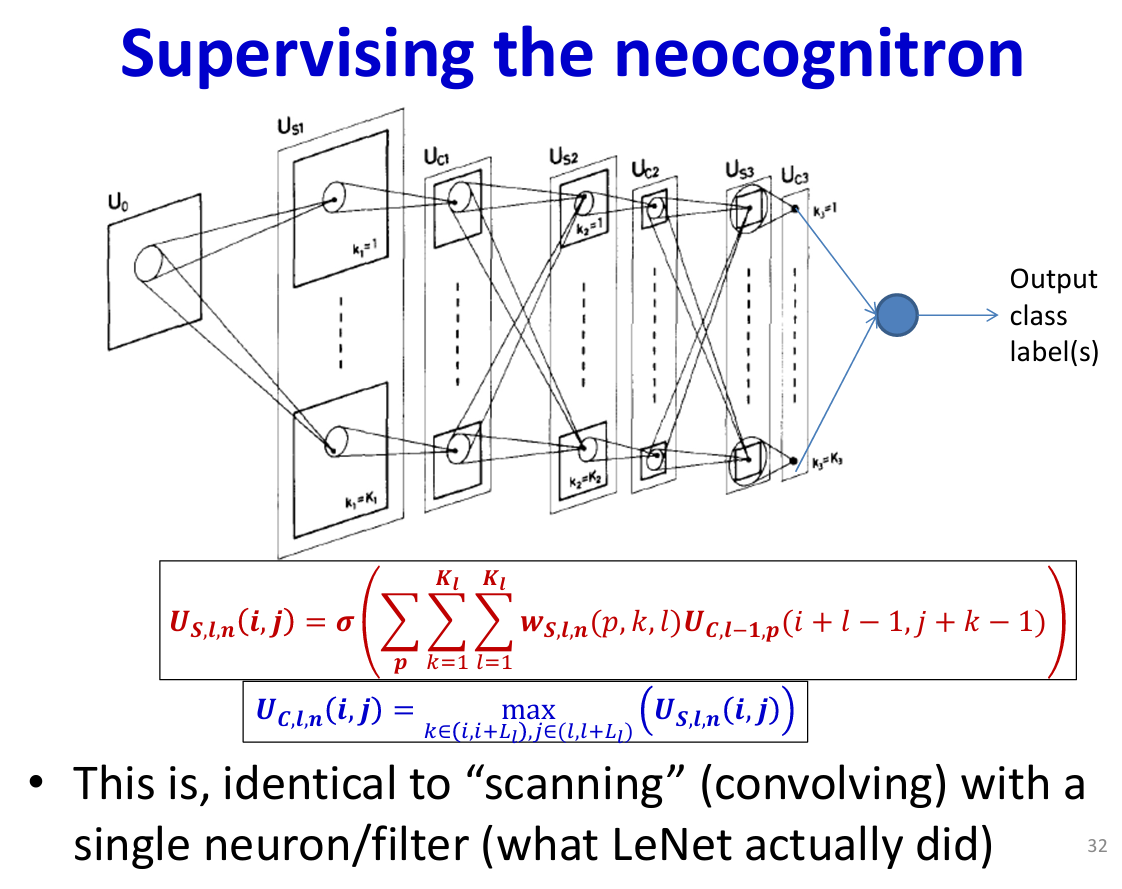

---

# General CNN Architecture

A Convolutional Neural Network (CNN) is a **hierarchical pattern-processing system** composed of three major blocks:

| Block | Name | Components | Learnable? |
|-------|------|------------|------------|
| **A** | Feature Extraction | Convolutional layers, Pointwise activations | ✅ Yes |
| **B** | Robustness & Compression | Pooling layers, Downsampling (stride) | ❌ Mostly No |
| **C** | Decision Making | Multi-Layer Perceptron (MLP), Softmax | ✅ Yes |

### Key Design Principle

$$\boxed{\text{Early layers} \rightarrow \text{local, simple patterns} \rightarrow \text{Deeper layers} \rightarrow \text{abstract patterns} \rightarrow \text{Final layers} \rightarrow \text{global reasoning}}$$

---

# Convolutional Layer

A convolutional layer comprises a series of **maps** — corresponding to the "S-planes" in the Neocognitron — variously called **feature maps** or **activation maps**.

Each activation map has two components:
1. An **affine map**, obtained by convolution over maps in the previous layer
2. An **activation** that operates pointwise on the output of the convolution

### Components of a Convolutional Layer

| Component | Description |
|-----------|-------------|
| **Input maps** | Feature maps from previous layer (or input image) |
| **Filters (kernels)** | Learnable weight tensors |
| **Affine map** | Pre-activation output: $\mathbf{Z} = \mathbf{W} * \mathbf{Y} + \mathbf{b}$ |
| **Activation function** | Pointwise nonlinearity: $\sigma(\cdot)$ |
| **Output activation maps** | Final feature maps: $\mathbf{Y}^{(l)} = \sigma(\mathbf{Z}^{(l)})$ |

> **Key insight:** Each output map corresponds to exactly **one filter**.

---

## What is a Convolution?

The convolution operation slides a filter over the input and computes weighted sums:

$$Z_{j}(x,y) = \sum_{p=1}^{D_{l-1}} \sum_{k=0}^{L-1} \sum_{l=0}^{L-1} W_{p,j}(k,l) \cdot Y_p(x+k, y+l) + b_j$$

where:
- $Z_j(x,y)$ = pre-activation at position $(x,y)$ for filter $j$
- $W_{p,j}(k,l)$ = filter weight at offset $(k,l)$ connecting input channel $p$ to output channel $j$
- $Y_p$ = input feature map $p$
- $b_j$ = bias for filter $j$

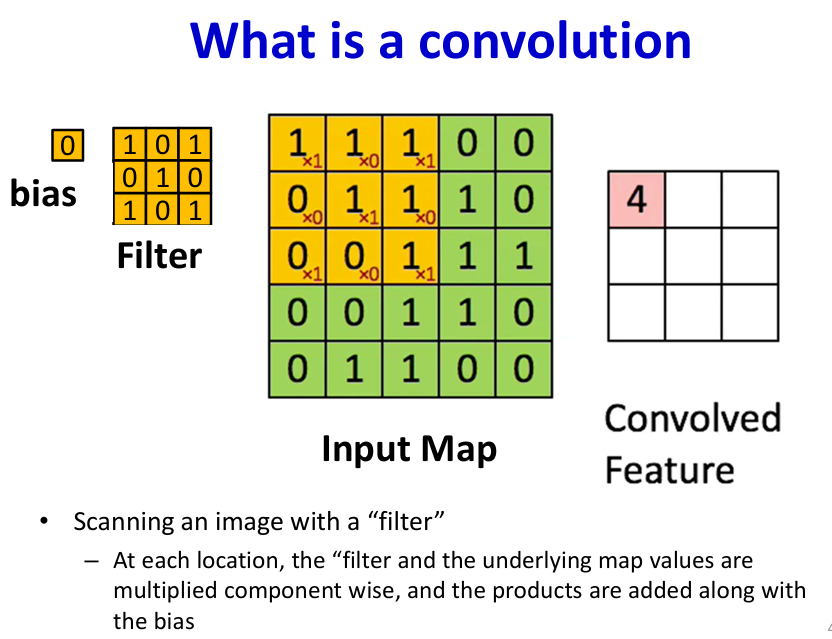

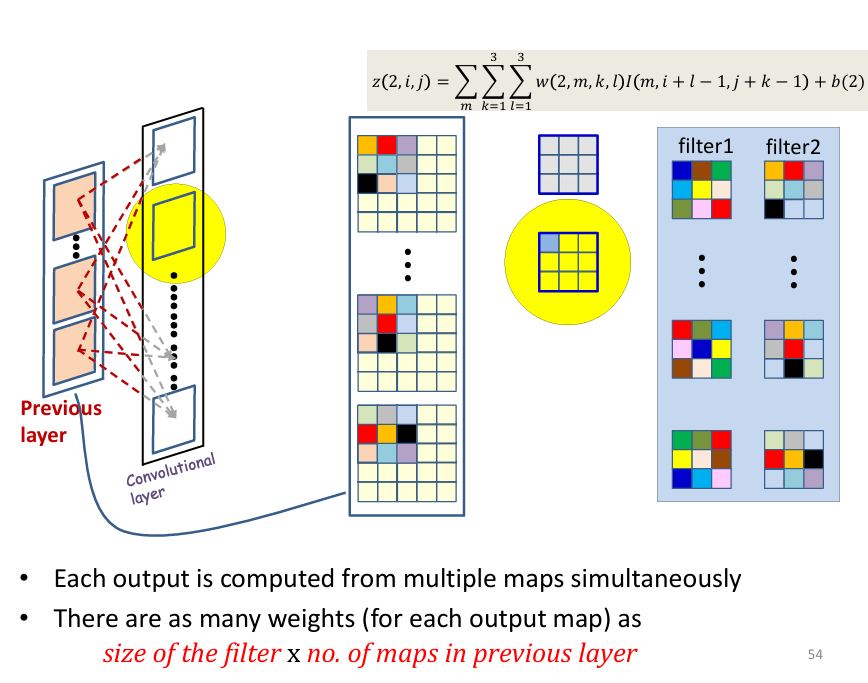

### A Different View

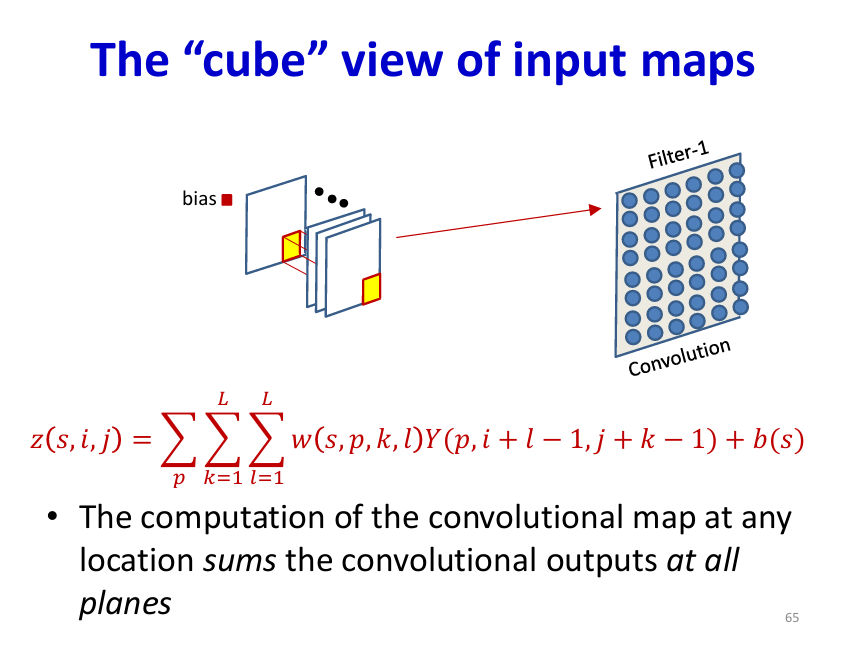

---

## What is a Filter?

### Definition

A **filter** (or kernel) is a small 3-D weight tensor:

$$\text{Filter dimensions} = L \times L \times D_{l-1}$$

where:
- $L$ = spatial kernel size (e.g., 3)
- $D_{l-1}$ = number of input channels/maps

### Example

| Parameter | Value |
|-----------|-------|
| Input maps | 16 |
| Filter spatial size | $3 \times 3$ |
| **Full filter tensor** | $3 \times 3 \times 16$ |

### Interpretation

> A filter is essentially a **single neuron** that is **reused (shared)** at every spatial location — this is the essence of **weight sharing**.

---

## Zero Padding

### Why Pad?

Without padding, convolution **shrinks** the spatial size of the feature map:

$$\text{Output size (no padding)} = (N - L + 1) \times (N - L + 1)$$

**Consequences without padding:**
- Border pixels are used **fewer times** than central pixels
- Spatial size **shrinks at every layer**
- Deep networks **lose resolution quickly**

### Padding Rules for Filter Width $L$

| Filter Size | Padding Amount |
|-------------|----------------|
| **Odd $L$** | Pad $\dfrac{L-1}{2}$ on both left and right |
| **Even $L$** | Pad $\dfrac{L}{2}$ on one side, $\dfrac{L}{2}-1$ on the other |

**Result with padding:**
- Padded image width: $N + L - 1$
- Output after convolution: $N$ (size preserved!)

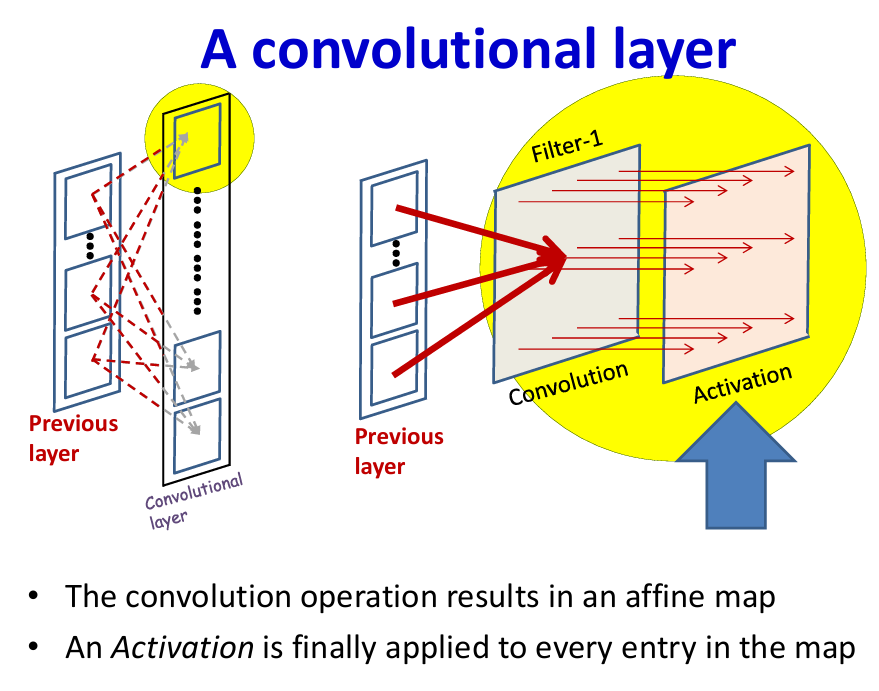

---

## Affine Map (The Core Convolution Computation)

### Step-by-Step Process

1. **Select a local patch** of size $L \times L$ from every input map
2. **Multiply element-wise:** patch values $\times$ corresponding filter weights
3. **Sum over:**
   - Spatial dimensions $(k, l)$
   - All input maps $p$
4. **Add bias** $b_j$

### Mathematical Formulation

$$z_j(x,y) = b_j + \sum_{p=1}^{D_{l-1}} \sum_{k=0}^{L-1} \sum_{l=0}^{L-1} w_{p,j}(k,l) \cdot y_p(x+k, y+l)$$

Then apply activation:

$$Y_j(x,y) = \sigma\left(z_j(x,y)\right)$$

---

## Pooling Layer (Non-Learnable, Fixed)

Pooling operates **independently on each map** and reduces spatial resolution.

### Properties

| Property | Value |
|----------|-------|
| Learnable weights | ❌ No |
| Changes number of maps | ❌ No |
| Reduces spatial size | ✅ Yes |

### Max Pooling Formula

For a pooling window of size $P \times P$ with stride $s$:

$$Y_{\text{pool}}(x,y) = \max_{0 \leq k,l < P} \left\{ Y(x \cdot s + k, \; y \cdot s + l) \right\}$$

### Average Pooling Formula

$$Y_{\text{pool}}(x,y) = \frac{1}{P^2} \sum_{k=0}^{P-1} \sum_{l=0}^{P-1} Y(x \cdot s + k, \; y \cdot s + l)$$

### Benefits of Pooling

- ✅ Robustness to **small shifts**
- ✅ Robustness to **noise**
- ✅ **Reduces computation** in subsequent layers

---

## Downsampling

Downsampling reduces spatial dimensions by **skipping positions** (using stride $S > 1$).

### Output Size Formula

$$\text{Output size} = \left\lfloor \frac{N + 2P - L}{S} \right\rfloor + 1$$

where:
- $N$ = input spatial size
- $P$ = padding
- $L$ = filter/pool size
- $S$ = stride

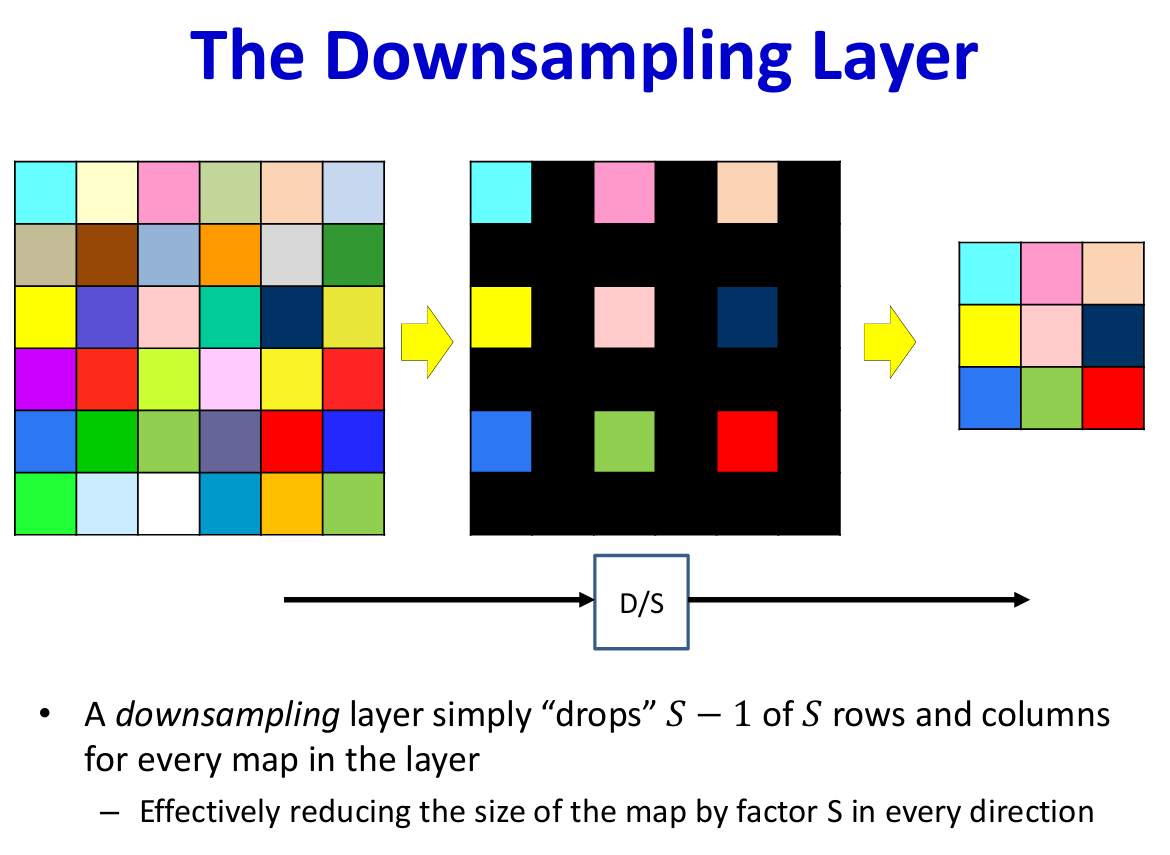

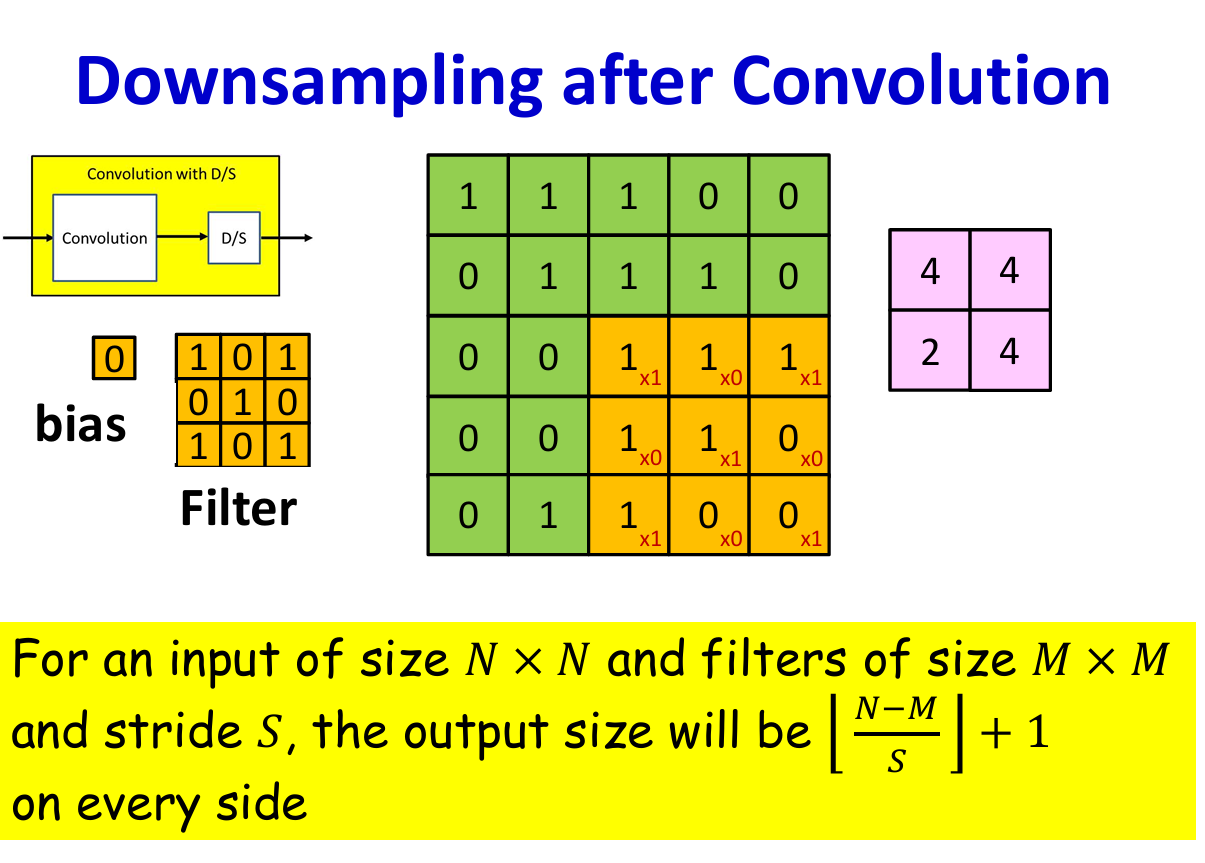

---

# Complete CNN Pipeline

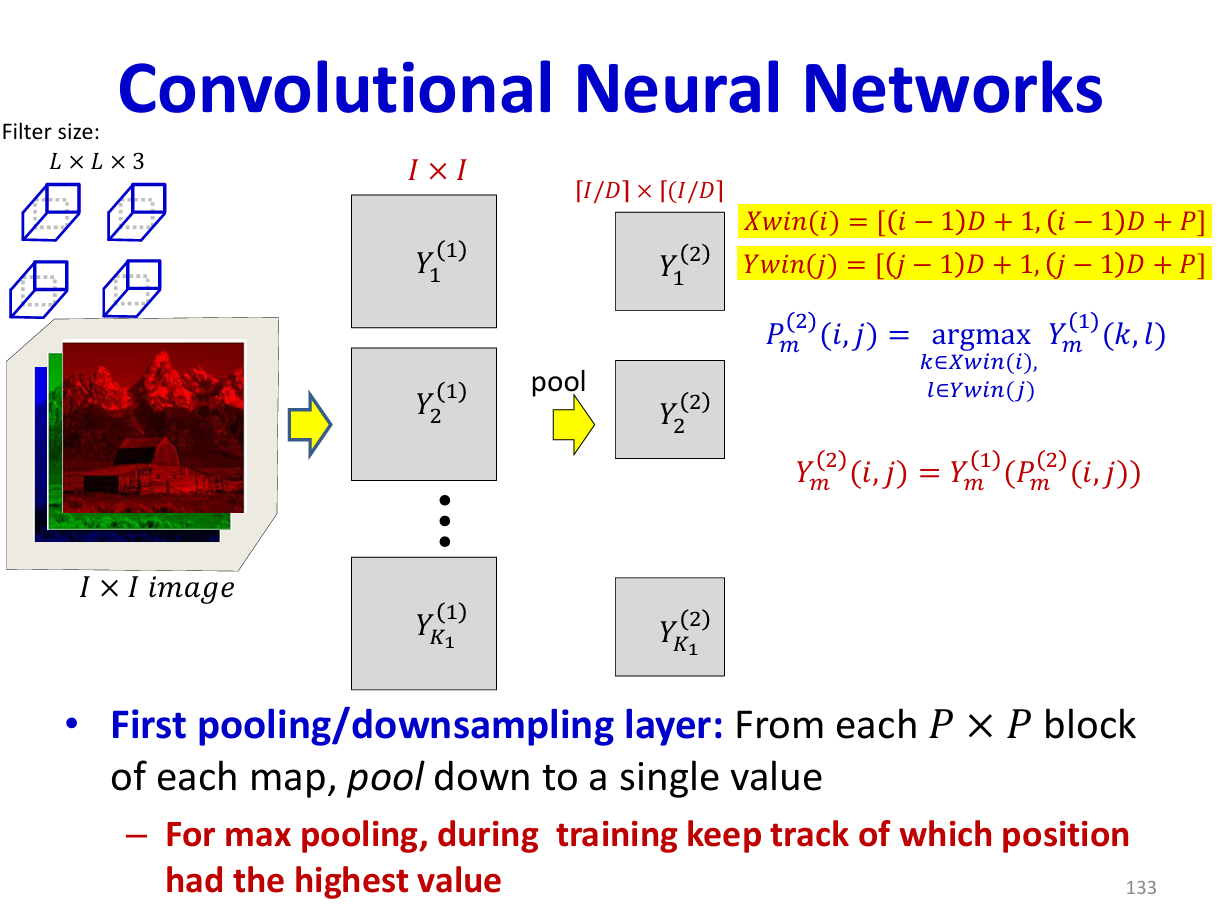

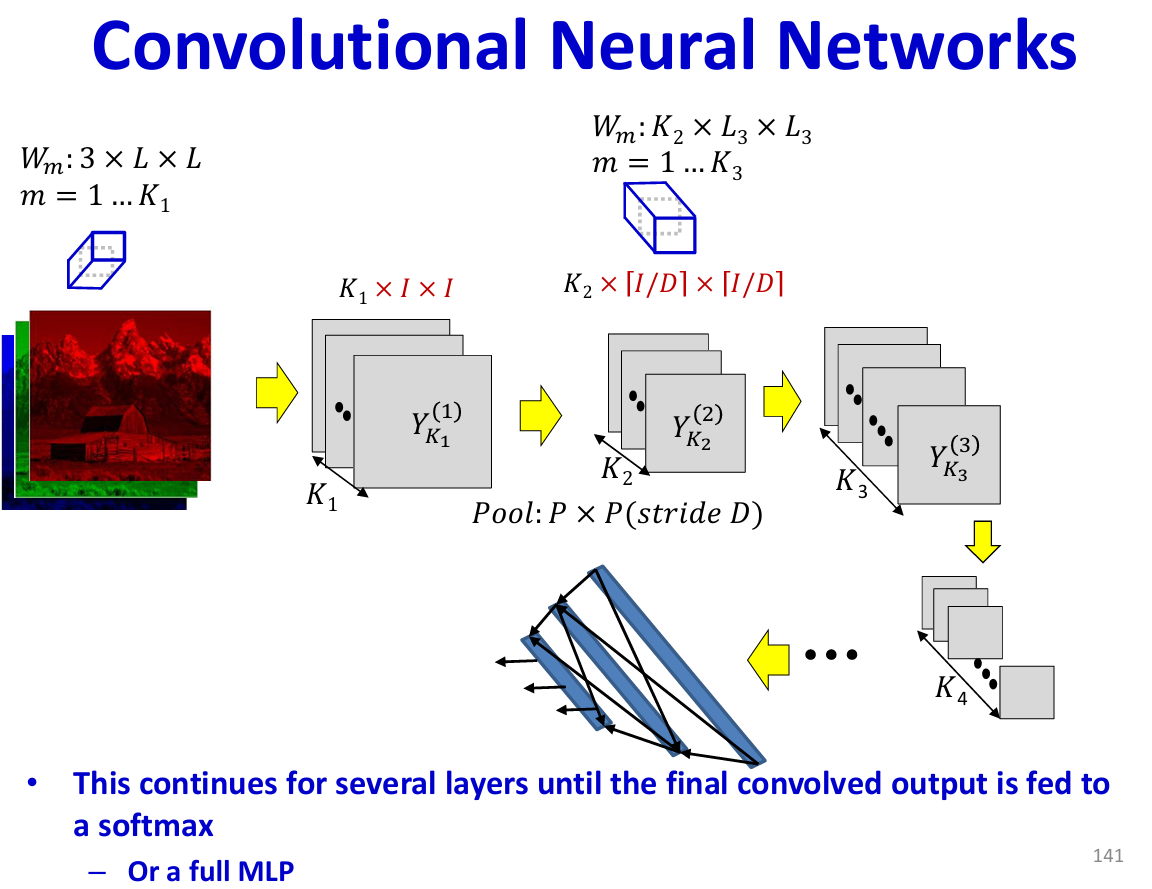

### Data Flow

```
Input Image
     ↓
Convolution    → learns local patterns (learnable weights)
     ↓
Activation     → adds nonlinearity (ReLU, etc.)
     ↓
Pooling        → robustness to small shifts (fixed)
     ↓
Downsampling   → spatial compression (via stride)
     ↓
   [Repeat layers hierarchically]
     ↓
Flatten        → convert feature maps to 1D vector
     ↓
MLP (FC)       → global reasoning (learnable)
     ↓
Softmax        → class probabilities
```

---

# Comparison: Convolution vs Pooling vs Downsampling

| Operation | Learns Parameters? | Combines Channels? | Changes Values? | Changes Size? | Main Purpose |
|-----------|:------------------:|:------------------:|:---------------:|:-------------:|--------------|
| **Convolution** | ✅ Yes | ✅ Yes | ✅ Yes | Maybe | Feature extraction |
| **Pooling** | ❌ No | ❌ No | ✅ Yes | ✅ Yes | Robustness |
| **Downsampling** | ❌ No | ❌ No | ❌ No | ✅ Yes | Compression |

---

## Complete Forward Pass Summary

| Step | Operation | Mathematical Expression |
|:----:|-----------|-------------------------|
| 1 | Input image enters CNN | $\mathbf{Y}^{(0)} = \text{Image} \in \mathbb{R}^{H \times W \times C}$ |
| 2 | Convolution computes affine maps | $\mathbf{Z}^{(l)} = \mathbf{W}^{(l)} * \mathbf{Y}^{(l-1)} + \mathbf{b}^{(l)}$ |
| 3 | Activation applied pointwise | $\mathbf{Y}^{(l)} = \sigma(\mathbf{Z}^{(l)})$ |
| 4 | Pooling compresses maps | $\mathbf{Y}^{(l)}_{\text{pool}} = \text{MaxPool}(\mathbf{Y}^{(l)})$ |
| 5 | Steps 2-4 repeat hierarchically | Build feature pyramid |
| 6 | Final maps flattened | $\mathbf{v} = \text{flatten}(\mathbf{Y}^{(L)}) \in \mathbb{R}^{d}$ |
| 7 | MLP produces output | $\hat{\mathbf{y}} = \text{softmax}(\mathbf{W}_{fc}\mathbf{v} + \mathbf{b}_{fc})$ |

---

## Named Components Checklist (For Exams & Diagrams)

| Category | Components |
|----------|------------|
| **Input** | Input image, Input tensor |
| **Feature Extraction** | Feature maps, Activation maps, Filters/Kernels |
| **Computation** | Affine map (pre-activation), Bias, Activation function |
| **Spatial Processing** | Pooling window, Stride, Downsampling, Zero padding |
| **Classification** | Flattening, Fully connected layer, Softmax/Output layer |